## Preparation (40 points total)

* [10 points] Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis. Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created).   
* [15 points] Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.
* [15 points] Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. Convince me that your cross validation method is a realistic mirroring of how an algorithm would be used in practice. 

## Modeling (50 points total)

* [20 points] Create a convolutional neural network to use on your data using tensorflow. 
* [20 points] Investigate at least two different deep network architectures. Use the method of cross validation and evaluation metric that you argued for at the beginning of the lab. Visualize the results of the CNNs. 
* [10 points] Compare the performance of your convolutional network to a standard multi-layer perceptron (MLP) using the receiver operating characteristic and area under the curve.   

## Exceptional Work (10 points total)

You have free reign to provide additional analyses.
One idea: Visualize the convolutional filters chosen by your CNN. Try to interpret some of their meanings.

In [1]:
from keras.datasets import cifar10
from keras.models import Sequential, Input, Model
from keras.layers import Reshape, Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, UpSampling2D
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping
import keras
from scipy import interp
import matplotlib.pyplot as plt
from sklearn import metrics as mt
import numpy as np
print(keras.__version__)

Using TensorFlow backend.


2.0.3


In [2]:
l2_lambda = 0.0001

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
NUM_CLASSES = 10
y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)

datagen = ImageDataGenerator(featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.
)
datagen.fit(x_train)

## Metrics

In [3]:
# from keras version < 2.0 https://github.com/fchollet/keras/commit/a56b1a55182acf061b1eb2e2c86b48193a0e88f7#diff-7b49e1c42728a58a9d08643a79f44cd4L134
from keras import backend as K
def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batcwise average of precision.

    Computes the precision, a metric for multlabel classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batcwise average of recall.

    Computes the recall, a metric for multlabel classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def fbeta_score(y_true, y_pred, beta=1):
    """Computes the F score.
 
    The F score is the weighted harmonic mean of precision and recall.
    Here it is only computed as a batchwise average, not globally.

    This is useful for multilabel classification, where input samples can be
    classified as sets of labels. By only using accuracy (precision) a model
    would achieve a perfect score by simply assigning every class to every
    input. In order to avoid this, a metric should penalize incorrect class
    assignments as well (recall). The Fbeta score (ranged from 0.0 to 1.0)
    computes this, as a weighted mean of the proportion of correct class
    assignments vs. the proportion of incorrect class assignments.

    With beta = 1, this is equivalent to a Fmeasure. With beta < 1, assigning
    correct classes becomes more important, and with beta > 1 the metric is
    instead weighted towards penalizing incorrect class assignments.
    """
    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')

    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score

 
def fmeasure(y_true, y_pred):
    """Computes the f-measure, the harmonic mean of precision and recall.

    Here it is only computed as a batch-wise average, not globally.
    """
    return fbeta_score(y_true, y_pred, beta=1)

In [11]:
# pretty confusion matrices

from sklearn import metrics as mt
from matplotlib import pyplot as plt
from skimage.io import imshow
import seaborn as sns
%matplotlib inline

def summarize_net(net, X_test, y_test, title_text=''):
    plt.figure(figsize=(15,5))
    yhat = np.argmax(net.predict(X_test), axis=1)
    acc = mt.accuracy_score(y_test,yhat)
    cm = mt.confusion_matrix(y_test,yhat)
    cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
    sns.heatmap(cm, annot=True, fmt='.2f')
    plt.title(title_text+'{:.4f}'.format(acc))
    

In [21]:
def plot_roc(probas, y_true):
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []

    classes = np.unique(y_true)
    perclass_mean_tpr = 0.0
    roc_auc = 0
    for j in classes:
        fpr, tpr, thresholds = mt.roc_curve(y_true, probas[:, j], pos_label=j)
        perclass_mean_tpr += interp(mean_fpr, fpr, tpr)
        perclass_mean_tpr[0] = 0.0
        roc_auc += mt.auc(fpr, tpr)

    perclass_mean_tpr /= len(classes)
    roc_auc /= len(classes)
    mean_tpr += perclass_mean_tpr

    plt.plot(mean_fpr,perclass_mean_tpr,'--',lw=1,label='Mean Class ROC for ensemble, AUC=%0.4f'
                     %(roc_auc))
    plt.legend(loc='best')
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.title('ROC Curve')
    

In [23]:
%%time
# build model
lenet = Sequential()
lenet.add(Conv2D(filters=6,kernel_size=(5,5),
               input_shape = (32,32,3), 
               padding='valid', 
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda)))
lenet.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))
lenet.add(BatchNormalization())
lenet.add(Activation("sigmoid"))
lenet.add(Conv2D(filters=16,kernel_size=(5,5), 
               padding='valid', 
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda)))
lenet.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))
lenet.add(BatchNormalization())
lenet.add(Activation("sigmoid"))
#lenet.add(Dropout(0.5))
lenet.add(Conv2D(filters=120,kernel_size=(1,1), 
               padding='valid', 
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda)))

lenet.add(Flatten())
lenet.add(Dense(84))
lenet.add(Activation("sigmoid"))
lenet.add(Dense(NUM_CLASSES))
lenet.add(Activation('softmax'))
lenet.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
                optimizer='rmsprop', # 'adadelta' 'rmsprop'
                metrics=['accuracy', fmeasure])

# the flow method yields batches of images indefinitely, with the given transofmrations
lenet.fit_generator(datagen.flow(x_train, y_train_ohe, batch_size=128), 
  steps_per_epoch=int(len(x_train)/128), # how many generators to go through per epoch
  epochs=50, verbose=2,
  validation_data=(x_test,y_test_ohe),
  callbacks=[EarlyStopping(monitor='val_loss', patience=10)]
 )

CPU times: user 12 µs, sys: 1e+03 ns, total: 13 µs
Wall time: 28.8 µs
Epoch 1/50
30s - loss: 1.7412 - acc: 0.3821 - fmeasure: 0.1785 - val_loss: 1.5565 - val_acc: 0.4479 - val_fmeasure: 0.2947
Epoch 2/50
29s - loss: 1.4739 - acc: 0.4809 - fmeasure: 0.3523 - val_loss: 1.7164 - val_acc: 0.4318 - val_fmeasure: 0.3686
Epoch 3/50
29s - loss: 1.3769 - acc: 0.5168 - fmeasure: 0.4207 - val_loss: 1.3493 - val_acc: 0.5197 - val_fmeasure: 0.4444
Epoch 4/50
29s - loss: 1.3195 - acc: 0.5404 - fmeasure: 0.4574 - val_loss: 1.3418 - val_acc: 0.5250 - val_fmeasure: 0.4647
Epoch 5/50
29s - loss: 1.2758 - acc: 0.5575 - fmeasure: 0.4832 - val_loss: 1.5011 - val_acc: 0.4894 - val_fmeasure: 0.4402
Epoch 6/50
29s - loss: 1.2434 - acc: 0.5676 - fmeasure: 0.5056 - val_loss: 1.2785 - val_acc: 0.5558 - val_fmeasure: 0.5087
Epoch 7/50
29s - loss: 1.2191 - acc: 0.5756 - fmeasure: 0.5172 - val_loss: 1.3883 - val_acc: 0.5306 - val_fmeasure: 0.5029
Epoch 8/50
29s - loss: 1.1953 - acc: 0.5833 - fmeasure: 0.5356 - val_

/usr/local/es7/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


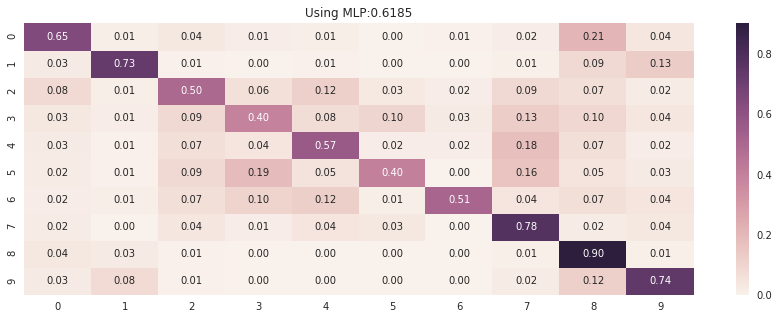

In [25]:
summarize_net(lenet, x_test, y_test, title_text='Using MLP:')

 9632/10000 [===========================>..] - ETA: 0s

/usr/local/es7/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


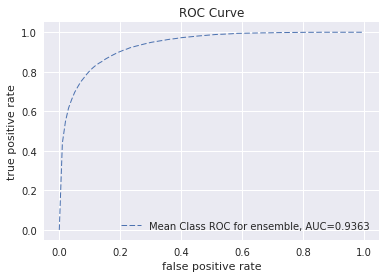

In [26]:
probas = lenet.predict_proba(x_test)
plot_roc(probas, y_test)

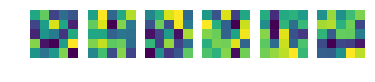

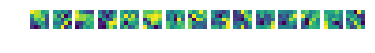

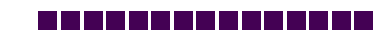

In [6]:
max_plots = 15
for layer in lenet.layers:
    if type(layer) == keras.layers.convolutional.Conv2D:
        weights = layer.get_weights()[0]
        for i in range(min(weights.shape[-1], max_plots)):
            plt.subplot(1, min(weights.shape[-1], max_plots), i+1)
            plt.imshow(weights[:,:,0,i])
            plt.axis('off')
        plt.show()


## MLP

In [5]:
%%time
mlp = Sequential()
mlp.add( Reshape((1,3072), input_shape=(32,32,3)) )
mlp.add( Flatten() )
mlp.add( Dense(input_dim=3072, units=30, activation='relu') )
mlp.add( Dense(units=15, activation='relu') )
mlp.add( Dense(NUM_CLASSES) )
mlp.add( Activation('softmax') )

mlp.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy', fmeasure])

mlp.fit(x_train, y_train_ohe, 
        batch_size=32, epochs=35, 
        shuffle=True, verbose=1)

CPU times: user 3 µs, sys: 3 µs, total: 6 µs
Wall time: 9.78 µs
Epoch 1/35
50000/50000 [==============================] - 7s - loss: 0.1800 - acc: 0.1000 - fmeasure: 0.1000     
Epoch 2/35
50000/50000 [==============================] - 7s - loss: 0.1800 - acc: 0.1000 - fmeasure: 0.1000     
Epoch 3/35
50000/50000 [==============================] - 7s - loss: 0.1800 - acc: 0.1000 - fmeasure: 0.1000     
Epoch 4/35
50000/50000 [==============================] - 7s - loss: 0.1800 - acc: 0.1000 - fmeasure: 0.1000     
Epoch 5/35
50000/50000 [==============================] - 7s - loss: 0.1800 - acc: 0.1000 - fmeasure: 0.1000     
Epoch 6/35
50000/50000 [==============================] - 7s - loss: 0.1800 - acc: 0.1000 - fmeasure: 0.1000     
Epoch 7/35
50000/50000 [==============================] - 7s - loss: 0.1800 - acc: 0.1000 - fmeasure: 0.1000     
Epoch 8/35
50000/50000 [==============================] - 7s - loss: 0.1800 - acc: 0.1000 - fmeasure: 0.1000     
Epoch 9/35
50000/50000 [

/usr/local/es7/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


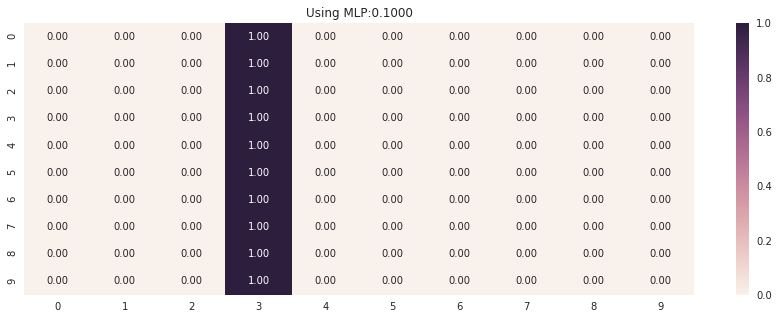

In [15]:
summarize_net(mlp, x_test, y_test, title_text='Using MLP:')

 9664/10000 [===========================>..] - ETA: 0s

/usr/local/es7/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


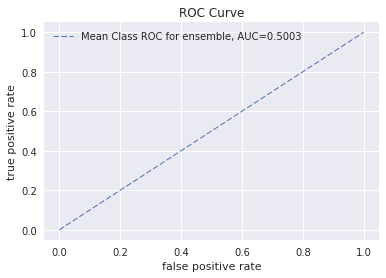

In [22]:
probas = mlp.predict_proba(x_test)
plot_roc(probas, y_test)